In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys, os
sys.path.insert(0, 'workspace/')
sys.path.insert(1, 'model/LLaVA-Med/llava')

import torch
import json
from tqdm import tqdm
import shortuuid

from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import tokenizer_image_token, get_model_name_from_path, KeywordsStoppingCriteria, process_images

from PIL import Image
import math
from transformers import set_seed

import random
import numpy as np
import matplotlib.pyplot as plt

In [3]:
!nvidia-smi

Tue Oct 22 16:20:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA TITAN RTX               Off | 00000000:03:00.0 Off |                  N/A |
| 90%   86C    P2             119W / 280W |  21635MiB / 24576MiB |    100%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
torch.cuda.set_device(1)
if torch.cuda.is_available():
    device = 'cuda'
    print(torch.cuda.current_device())

1


## Inference LLaVA-Med - code from `llava/eval/model_vqa.py`

In [5]:
args_model_path = 'microsoft/llava-med-v1.5-mistral-7b'
args_guestion_file = 'data/eval/llava_med_eval_qa50_qa.jsonl'
args_conv_mode = 'mistral_instruct'
args_image_folder = 'data/images'
args_answers_file = 'answer-file_test.jsonl'

args_temperature = 0.0
args_num_chunks = 1
args_chunk_idx = 0
args_top_p = None
args_num_beams = 1

Load model, tokenizer, ...

In [6]:
model_path = os.path.expanduser(args_model_path)
model_name = get_model_name_from_path(model_path)
print(f'Model name: {model_name.lower()}')

set_seed(0)
# Model
disable_torch_init()
# tokenizer, model, image_processor, context_len = load_pretrained_model(model_path, None, model_name)
tokenizer, model, image_processor, context_len = load_pretrained_model(model_path, None, model_name, load_8bit=False, load_4bit=False, device="cuda")

Model name: llava-med-v1.5-mistral-7b


/opt/miniconda/envs/llava-med/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]
Some weights of the model checkpoint at microsoft/llava-med-v1.5-mistral-7b were not used when initializing LlavaMistralForCausalLM: ['model.vision_tower.vision_tower.vision_model.encoder.layers.16.mlp.fc1.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.8.self_attn.v_proj.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.10.layer_norm2.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.9.mlp.fc2.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.14.mlp.fc2.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.18.layer_norm1.weig

In [7]:
def split_list(lst, n):
    """Split a list into n (roughly) equal-sized chunks"""
    chunk_size = math.ceil(len(lst) / n)  # integer division
    return [lst[i:i+chunk_size] for i in range(0, len(lst), chunk_size)]


def get_chunk(lst, n, k):
    chunks = split_list(lst, n)
    return chunks[k]

Load questions

In [8]:
questions = [json.loads(q) for q in open(os.path.join('model/LLaVA-Med/', args_guestion_file), "r")]
print(len(questions))
questions = get_chunk(questions, args_num_chunks, args_chunk_idx)

193


Example of question with image and GPT4 answer

90: Question: What does the green arrow point to in the left image?
Image name: 30279704_F3.jpg


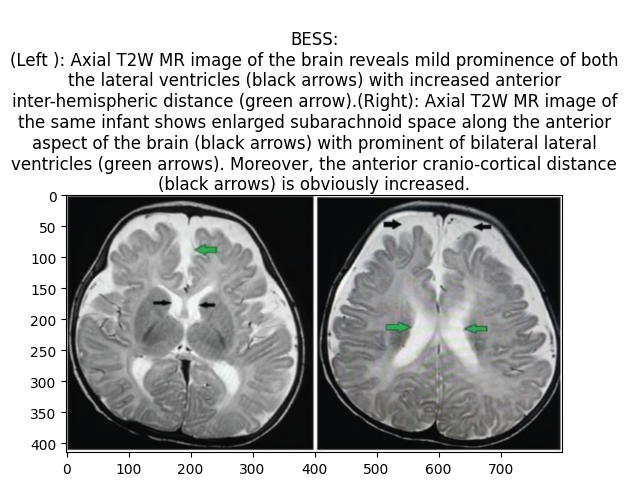

GPT4 answer: In the left axial T2W MR image, the green arrow points to the increased anterior inter-hemispheric distance.


In [9]:
line = questions[90]
idx = line["question_id"]
image_file = line["image"]
qs = line["text"].replace(DEFAULT_IMAGE_TOKEN, '').strip()

print(f'{idx}: Question: {qs}')

print(f'Image name: {image_file}')
image = Image.open(os.path.join('model/LLaVA-Med', args_image_folder, image_file))
plt.imshow(image)
plt.title(line["fig_caption"], wrap=True)
plt.show()

answer = line["gpt4_answer"]
print(f'GPT4 answer: {answer}')

#### Inference on evaluation dataset

Create answer file

In [9]:
answers_file = os.path.expanduser(args_answers_file)
# os.makedirs(os.path.dirname(answers_file), exist_ok=True)
ans_file = open(answers_file, "w")

In [11]:
for line in tqdm(questions):
    # get question and image file name
    idx = line["question_id"]
    image_file = line["image"]
    qs = line["text"].replace(DEFAULT_IMAGE_TOKEN, '').strip()
    cur_prompt = qs
    if model.config.mm_use_im_start_end:
        qs = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + qs
    else:
        qs = DEFAULT_IMAGE_TOKEN + '\n' + qs

    # get prompt from template and question
    conv = conv_templates[args_conv_mode].copy()
    conv.append_message(conv.roles[0], qs)
    conv.append_message(conv.roles[1], None)
    prompt = conv.get_prompt()

    # tokenize prompt
    input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()

    # load image
    image = Image.open(os.path.join('LLaVA-Med', args_image_folder, image_file))
    image_tensor = process_images([image], image_processor, model.config)[0]

    # stopping criteria - is it used further?
    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    keywords = [stop_str]
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)

    # generate answer
    with torch.inference_mode():
        output_ids = model.generate(
            input_ids,
            images=image_tensor.unsqueeze(0).half().cuda(),
            do_sample=True if args_temperature > 0 else False,
            temperature=args_temperature,
            top_p=args_top_p,
            num_beams=args_num_beams,
            # no_repeat_ngram_size=3,
            output_hidden_states=True,
            max_new_tokens=1024,
            use_cache=True)

    outputs = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip()

    ans_id = shortuuid.uuid()
    ans_file.write(json.dumps({"question_id": idx,
                                "prompt": cur_prompt,
                                "text": outputs,
                                "answer_id": ans_id,
                                "model_id": model_name,
                                "metadata": {}}) + "\n")
    ans_file.flush()
ans_file.close()

  0%|          | 0/193 [00:00<?, ?it/s]/home/jovyan/shares/SR004.nfs2/druzhinina/miniconda3/envs/videvo_cuda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/jovyan/shares/SR004.nfs2/druzhinina/miniconda3/envs/videvo_cuda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:394: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `None` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end gen

#### Compare LLaVA-Med answers with GPT4 answers

In [10]:
llava_answers = [json.loads(a) for a in open('answer-file_test.jsonl', "r")]
print(len(llava_answers))

0


163: Question: Characterize the image using a well-detailed description
Image name: 27679760_fig2.jpg


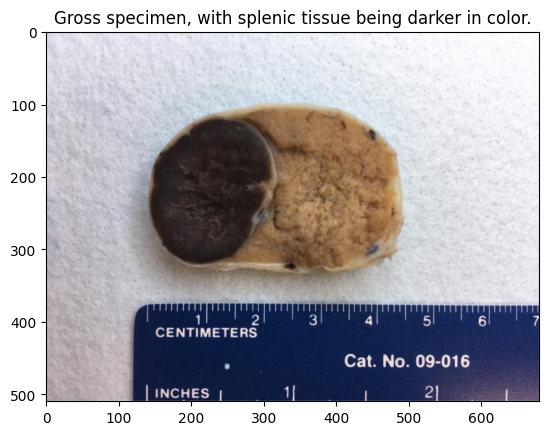

GPT4 answer: The image displays a gross specimen, showcasing a clear contrast between two types of tissues. The splenic tissue appears darker in color compared to the adjacent testicular tissue. The boundary between these tissues is well-defined, as the splenic tissue is encapsulated by a fibrous layer, visually separating it from the testicular tissue. The overall appearance of the image highlights the distinct characteristics of both tissues, making it easy to differentiate between them.

LLaVA-Med answer: The image is a gross specimen of a resected tumor. It is characterized by a well-circumscribed, lobulated, and encapsulated mass. The cut surface of the tumor shows a homogeneous tan-white color with a focal area of hemorrhage.

--------------------------------

28: Question: What was the purpose of the thoracoplasty in this case?
Image name: 21139713_F0003.jpg


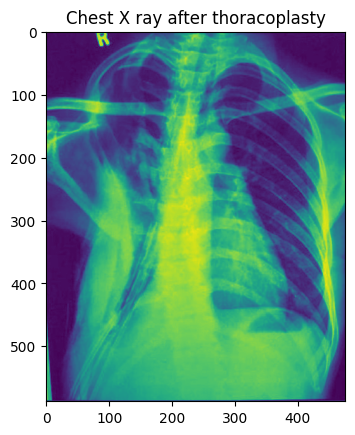

GPT4 answer: In this specific case, the thoracoplasty was performed as an additional procedure for a patient with tuberculous empyema. Tuberculous empyema is a condition where pus accumulates in the pleural space due to a tuberculosis infection. The thoracoplasty was likely performed to help manage the infection and improve the patient's condition by collapsing a part of the chest cavity.

LLaVA-Med answer: The purpose of the thoracoplasty in this case was to address the patient's pneumothorax, which is a condition where air accumulates in the pleural space, causing the lung to collapse. The thoracoplasty was performed to remove the air and re-expand the lung, as well as to prevent recurrence of the pneumothorax.

--------------------------------

6: Question: What is the difference between the images of the depressed patient and the healthy control subject?
Image name: 18652673_F3.jpg


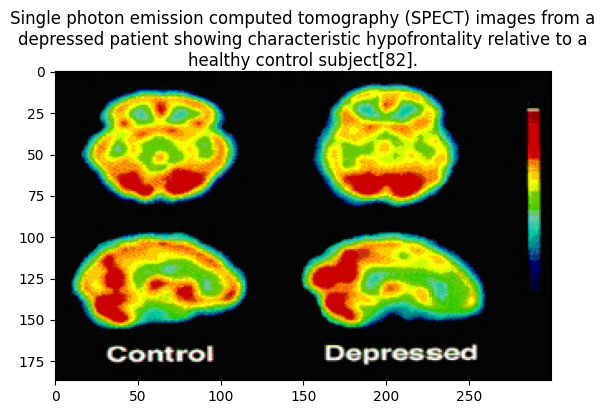

GPT4 answer: The difference between the images of the depressed patient and the healthy control subject is the presence of hypofrontality in the depressed patient. Hypofrontality refers to decreased activity in the prefrontal cortex (PFC), which can be observed as reduced cerebral blood flow (CBF) and glucose metabolism in the PFC, particularly in the dorsolateral prefrontal cortex (DLPFC). This is a characteristic finding in neuroimaging studies of depression.

LLaVA-Med answer: The difference between the images of the depressed patient and the healthy control subject is the level of glucose metabolism in the brain. The depressed patient shows a significant decrease in glucose metabolism in the left frontal lobe, left parietal lobe, and left occipital lobe compared to the healthy control subject. This suggests that there may be differences in brain function or structure between the depressed patient and the healthy individual.

--------------------------------

189: Question: Describe

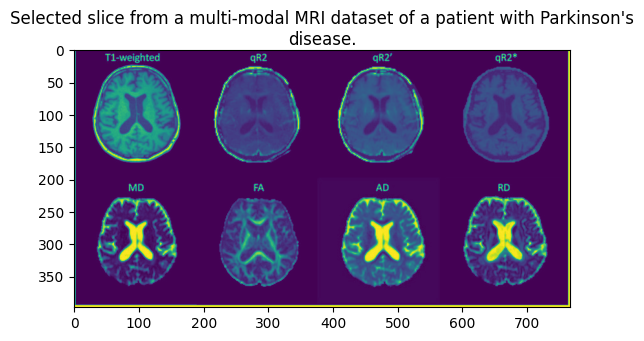

GPT4 answer: The image is a selected slice from a multi-modal MRI dataset of a patient with Parkinson's disease. It is a high-resolution, grayscale image that showcases the intricate details of the patient's brain anatomy. The MRI scan was performed using a 3T Siemens Skyra MR scanner at a university medical center.

In the image, various brain structures can be observed, such as the cerebral cortex, white matter, and deep brain nuclei. The contrast between different tissue types is evident, allowing for a clear distinction between gray and white matter. The image also highlights any potential abnormalities or changes in the brain structure that may be associated with Parkinson's disease.

Overall, the image provides valuable insights into the brain's anatomy and the potential effects of Parkinson's disease on the patient's brain.

LLaVA-Med answer: The image is a series of MRI scans of the brain, showing different stages of the patient's condition. The top row of images represents the

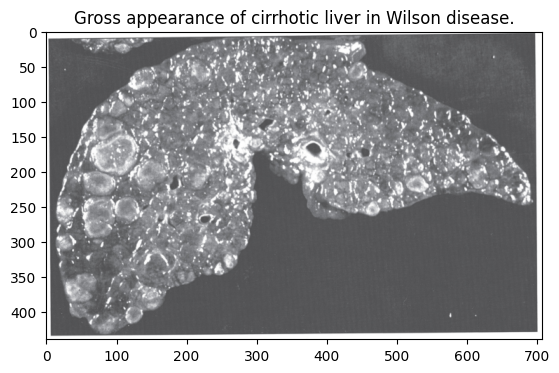

GPT4 answer: The cirrhotic liver in the image is associated with Wilson disease, a rare genetic disorder that causes excessive copper accumulation in the liver, brain, and other vital organs. This accumulation can lead to liver damage and cirrhosis, as seen in the image.

LLaVA-Med answer: The liver condition shown in the image is associated with primary biliary cirrhosis (PBC).

--------------------------------



In [15]:
random.seed(42)
ridxs = random.sample(range(len(llava_answers)), 5)

for q, a in zip(np.array(questions)[ridxs], np.array(llava_answers)[ridxs]):
    idx = q["question_id"]
    assert idx == a["question_id"]
    
    image_file = q["image"]
    qs = q["text"].replace(DEFAULT_IMAGE_TOKEN, '').strip()

    print(f'{idx}: Question: {qs}')

    print(f'Image name: {image_file}')
    image = Image.open(os.path.join('LLaVA-Med', args_image_folder, image_file))
    plt.imshow(image)
    plt.title(q["fig_caption"], wrap=True)
    plt.show()


    gpt4_answer = q["gpt4_answer"]
    print(f'GPT4 answer: {gpt4_answer}')

    llava_answer = a["text"]
    print(f'\nLLaVA-Med answer: {llava_answer}')

    print('\n--------------------------------\n')

### Get embeddings from all layers

Сейчас в методе для генерации ответа и сбора эмбедингов со всех слоев добавлен костыль - при обнаружении nan в ембедингах повторно генерируется токен

In [9]:
def generate_with_embeddings(model, tokenizer, line, max_new_tokens=1024):
    # get question and image file name
    image_file = line["image"]
    qs = line["text"].replace(DEFAULT_IMAGE_TOKEN, '').strip()
    if model.config.mm_use_im_start_end:
        qs = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + qs
    else:
        qs = DEFAULT_IMAGE_TOKEN + '\n' + qs

    # get prompt from template and question
    conv = conv_templates[args_conv_mode].copy()
    conv.append_message(conv.roles[0], qs)
    conv.append_message(conv.roles[1], None)
    prompt = conv.get_prompt()

    # tokenize prompt
    input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()

    # load image
    image = Image.open(os.path.join('model/LLaVA-Med', args_image_folder, image_file))
    image_tensor = process_images([image], image_processor, model.config)[0]

    # Initial sequence of tokens
    inp_len = input_ids.shape[-1]
    generated_ids = input_ids
    all_hidden_states = [] # List for storing embeddings from every layer
    it = 0
    model.eval()
    with torch.no_grad():
        for _ in range(max_new_tokens):

                # Call forward model to get embeddings and logits
                outputs = model(
                    input_ids=generated_ids,
                    images=image_tensor.unsqueeze(0).half().cuda(),
                    output_hidden_states=True,  # Turn on hidden states return
                    use_cache=False,
                )
                for i, hidden_state in enumerate(outputs.hidden_states):
                    if torch.isnan(hidden_state).any():
                        print(f"NaN detected in layer {i}. Regenerating token...")

                all_hidden_states.append(outputs.hidden_states)
                # Last token's logits
                next_token_logits = outputs.logits[:, -1, :]
                next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(0)
                
                # Add predicted token to the sequence
                generated_ids = torch.cat([generated_ids, next_token], dim=-1)
                
                torch.cuda.empty_cache()
                # Stop generation, if we got End Of Sequence (EOS) token
                if next_token.item() == tokenizer.eos_token_id:
                    break

    # Trasform predicted tokens back to the text
    model_output = generated_ids[..., inp_len:] # take model generated token
    output_text = tokenizer.batch_decode(model_output, skip_special_tokens=True)[0].strip()

    # Clean cache
    torch.cuda.empty_cache()

    return input_ids, image_tensor, output_text, all_hidden_states

90: Question: What does the green arrow point to in the left image?
Image name: 30279704_F3.jpg


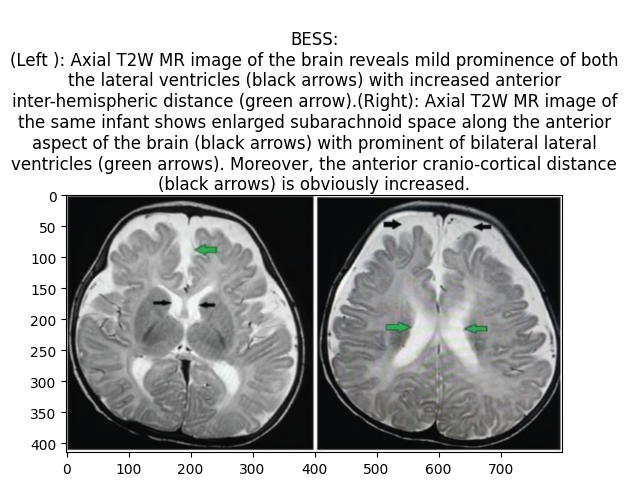

GPT4 answer: In the left axial T2W MR image, the green arrow points to the increased anterior inter-hemispheric distance.
Output: In the left image, the green arrow points to a hyperintense signal in the right thal


In [40]:
# Generate answer and get embeddings
line = questions[90]
idx = line["question_id"]
image_file = line["image"]
qs = line["text"].replace(DEFAULT_IMAGE_TOKEN, '').strip()

print(f'{idx}: Question: {qs}')

print(f'Image name: {image_file}')
image = Image.open(os.path.join('model/LLaVA-Med', args_image_folder, image_file))
plt.imshow(image)
plt.title(line["fig_caption"], wrap=True)
plt.show()

answer = line["gpt4_answer"]
print(f'GPT4 answer: {answer}')
input_ids, _, output_text, all_hidden_states = generate_with_embeddings(model, tokenizer, line, max_new_tokens=20)
print(f'Output: {output_text}')

for i, hidden_state in enumerate(all_hidden_states):
    hs  = torch.stack(list(hidden_state), dim=0)
    if torch.isnan(hs).any():
        print(f"NaN detected in layer {i}. Regenerating token...")

In [12]:
j = -1
hidden_values_count = torch.numel(all_hidden_states[j][0])
for i in range(len(all_hidden_states[j])):
    hidden_states = all_hidden_states[j][i]
    finite_values = torch.isfinite(hidden_states).sum()
    print(f'Layer {i}: finite percent: {(finite_values / hidden_values_count * 100, )}')

Layer 0: finite percent: (tensor(100., device='cuda:1'),)
Layer 1: finite percent: (tensor(100., device='cuda:1'),)
Layer 2: finite percent: (tensor(100., device='cuda:1'),)
Layer 3: finite percent: (tensor(100., device='cuda:1'),)
Layer 4: finite percent: (tensor(100., device='cuda:1'),)
Layer 5: finite percent: (tensor(100., device='cuda:1'),)
Layer 6: finite percent: (tensor(100., device='cuda:1'),)
Layer 7: finite percent: (tensor(100., device='cuda:1'),)
Layer 8: finite percent: (tensor(100., device='cuda:1'),)
Layer 9: finite percent: (tensor(100., device='cuda:1'),)
Layer 10: finite percent: (tensor(100., device='cuda:1'),)
Layer 11: finite percent: (tensor(100., device='cuda:1'),)
Layer 12: finite percent: (tensor(100., device='cuda:1'),)
Layer 13: finite percent: (tensor(100., device='cuda:1'),)
Layer 14: finite percent: (tensor(100., device='cuda:1'),)
Layer 15: finite percent: (tensor(100., device='cuda:1'),)
Layer 16: finite percent: (tensor(100., device='cuda:1'),)
Layer 1

In [13]:
len(all_hidden_states), len(all_hidden_states[0]), all_hidden_states[0][-1].shape, all_hidden_states[-1][-1].shape

(20, 33, torch.Size([1, 599, 4096]), torch.Size([1, 618, 4096]))

#### Formula for embeddings: 5 start service tokens + 576 image tokens + 2 service tokens + k text tokens + 4 service tokens -> enbeddings

Try encode image by vision encoder

In [39]:
vision_tower = model.get_vision_tower()

image_tensor = process_images([image], image_processor, model.config)[0]
image_tensor.shape

t = vision_tower([image_tensor])
t[0].shape

torch.Size([1, 576, 1024])

In [14]:
def get_image_text_idxs(input_ids, tokenizer, emb_len, img_special_token=IMAGE_TOKEN_INDEX, img_tokens_len=576):
    # define service tokens len
    start_tokens_len = len(tokenizer('[INST]').input_ids)
    end_tokens_len = len(tokenizer('[/INST]').input_ids) - 1
    middle_tokens_len = len(tokenizer('\n').input_ids) - 1
    # get special image toekn position
    img_spec_token_pos = (input_ids[0] == IMAGE_TOKEN_INDEX).nonzero(as_tuple=True)[0]
    assert start_tokens_len == img_spec_token_pos - 1
    # define text tokens indexes in input prompt
    text_tokens_idxs = np.array(range(img_spec_token_pos + middle_tokens_len + 1, len(input_ids[0]))) #  - end_tokens_len
    print(tokenizer.convert_ids_to_tokens(input_ids[0][text_tokens_idxs]))
    # define image, text tokens indexes
    image_token_idxs = np.arange(start_tokens_len + 1, start_tokens_len + img_tokens_len + 1)
    text_tokens_idxs = text_tokens_idxs + img_tokens_len - 1

    return image_token_idxs, text_tokens_idxs

In [42]:
img_emb_idxs, text_emb_idxs = get_image_text_idxs(input_ids, tokenizer, emb_len=599)
len(img_emb_idxs), len(text_emb_idxs)

['What', '▁does', '▁the', '▁green', '▁arrow', '▁point', '▁to', '▁in', '▁the', '▁left', '▁image', '?', '▁[', '/', 'INST', ']']


(576, 16)

## Calculate statistics

In [10]:
import torch
from microscope_functions import  (
  calculate_anisotropy_torch,
  intrinsic_dimension,
  procrustes_similarity,
  procrustes_similarity_centered,
)

In [100]:
# X = torch.randn((1000, 10)) # pseudo-random "features", 1000 vectors with dim=10.
# Y = torch.randn((1000, 10)) # pseudo-random "features", 1000 vectors with dim=10.

# anisotropy = calculate_anisotropy_torch(X) # anisotropy score
# int_dim = intrinsic_dimension(X, device) # intrinsic dimension
# linearity_score = procrustes_similarity(X, Y) # linearity score from the paper
# centered_linearity_score = procrustes_similarity_centered(X, Y) # the same as linearity between X and Y - X
# anisotropy, int_dim, linearity_score, centered_linearity_score

In [11]:
questions = [json.loads(q) for q in open(os.path.join('model/LLaVA-Med/', args_guestion_file), "r")]
print(len(questions))

193


In [15]:
def get_embeddings(model, tokenizer, questions, sample_number=64):
    if sample_number < len(questions):
        random.seed(42)
        idxs = random.sample(range(len(questions)), sample_number)
    else:
        idxs = range(len(questions))
    layer2embs = {}
    # sample_img_text_idxs = []
    with torch.no_grad():
        for j in tqdm(idxs, desc='Collecting embeddings'):
            # get question dict
            line = questions[j]
            # get input_ids, output and hidden_states
            input_ids, _, output_text, all_hidden_states = generate_with_embeddings(model, tokenizer, line, max_new_tokens=1)
            hidden_states = all_hidden_states[0]
            img_emb_idxs, text_emb_idxs = get_image_text_idxs(input_ids, tokenizer, emb_len=hidden_states[0].shape[1])
            print(len(img_emb_idxs), len(text_emb_idxs))
            if len(img_emb_idxs) != 576:
                print(f"Something wrong with indexes for sample {j}.")

            # sample_img_text_idxs.append((img_emb_idxs, text_emb_idxs))

            # collect hidden states in dict by layers
            for i, emb in enumerate(hidden_states):
                if i in layer2embs:
                    # layer2embs[i] += list(emb.cpu().detach()[0])
                    if j % 3 == 0: # иначе будет слишком много примеров
                        layer2embs[i]['img'] += list(emb.cpu().detach()[0][img_emb_idxs])
                    layer2embs[i]['text'] += list(emb.cpu().detach()[0][text_emb_idxs]) 
                else:
                    # layer2embs[i] = list(emb.cpu().detach()[0])
                    layer2embs[i] = { 
                                     'img': list(emb.cpu().detach()[0][img_emb_idxs]), 
                                     'text': list(emb.cpu().detach()[0][text_emb_idxs]) 
                                    }

        for i in range(len(hidden_states)):
            layer2embs[i]['img'] = torch.stack(layer2embs[i]['img'])
            layer2embs[i]['text'] = torch.stack(layer2embs[i]['text'])
            
        return layer2embs

In [16]:
all_results = {
    'procrustes_similarity': {},
    'procrustes_similarity_centered': {},
    'intrinsic_dimension': {},
    'anisotropy': {}
}

save_path = 'workspace/results_img_text_emb.json'

with torch.no_grad():   
    torch.cuda.empty_cache()
    print(f'Starting tests for model {model_name}')
    embs_dict = get_embeddings(model, tokenizer, questions, sample_number=193)
    print(f"Embs shape - img: {embs_dict[0]['img'].shape} text: {embs_dict[0]['text'].shape}")

Starting tests for model llava-med-v1.5-mistral-7b


['What', '▁is', '▁the', '▁organ', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁type', '▁of', '▁cells', '▁are', '▁l', 'ining', '▁the', '▁c', 'yst', 'ic', '▁wall', '?', '▁[', '/', 'INST', ']']
576 17


['Are', '▁there', '▁any', '▁infl', 'am', 'mat', 'ory', '▁cells', '▁present', '?', '▁[', '/', 'INST', ']']
576 14


['What', '▁is', '▁the', '▁difference', '▁between', '▁the', '▁W', 'inn', 'ie', '▁and', '▁wild', '-', 'type', '▁m', 'ice', '?', '▁[', '/', 'INST', ']']
576 20


['What', '▁is', '▁the', '▁purpose', '▁of', '▁the', '▁st', 'aining', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁is', '▁the', '▁role', '▁of', '▁gob', 'let', '▁cells', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁is', '▁the', '▁difference', '▁between', '▁the', '▁images', '▁of', '▁the', '▁depressed', '▁patient', '▁and', '▁the', '▁healthy', '▁control', '▁subject', '?', '▁[', '/', 'INST', ']']
576 21


['What', '▁imag', 'ing', '▁technique', '▁was', '▁used', '?', '▁[', '/', 'INST', ']']
576 11


['What', '▁does', '▁hyp', 'o', 'front', 'ality', '▁indicate', '?', '▁[', '/', 'INST', ']']
576 12
['What', '▁is', '▁the', '▁yellow', '▁wave', 'form', '▁representing', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁does', '▁the', '▁time', '-', 'frequency', '▁plot', '▁illustr', 'ate', '?', '▁[', '/', 'INST', ']']
576 14


['What', '▁does', '▁the', '▁lower', '▁right', '▁panel', '▁show', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁does', '▁the', '▁chest', '▁X', '-', 'ray', '▁show', '?', '▁[', '/', 'INST', ']']
576 13


['Are', '▁there', '▁any', '▁signs', '▁of', '▁l', 'ym', 'ph', '▁node', '▁involvement', '?', '▁[', '/', 'INST', ']']
576 15


['What', '▁about', '▁met', 'ast', 'ases', '?', '▁[', '/', 'INST', ']']
576 10


['What', '▁organ', '▁is', '▁shown', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁is', '▁the', '▁main', '▁feature', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁type', '▁of', '▁tum', 'or', '▁is', '▁mentioned', '▁in', '▁the', '▁context', '?', '▁[', '/', 'INST', ']']
576 15


['What', '▁is', '▁the', '▁image', '▁showing', '?', '▁[', '/', 'INST', ']']
576 10


['How', '▁many', '▁inf', 'ants', '▁had', '▁a', '▁differential', '▁score', '▁of', '▁', '≥', '1', '▁for', '▁infl', 'amm', 'ation', '?', '▁[', '/', 'INST', ']']
576 21


['How', '▁many', '▁inf', 'ants', '▁had', '▁a', '▁differential', '▁score', '▁of', '▁', '≥', '2', '▁for', '▁fib', 'ros', 'is', '?', '▁[', '/', 'INST', ']']
576 21


['What', '▁is', '▁the', '▁main', '▁finding', '▁in', '▁the', '▁orb', 'ital', '▁M', 'RI', '?', '▁[', '/', 'INST', ']']
576 16


['What', '▁does', '▁pro', 'pt', 'osis', '▁mean', '?', '▁[', '/', 'INST', ']']
576 11


['What', '▁can', '▁you', '▁say', '▁about', '▁the', '▁extra', 'oc', 'ular', '▁muscles', '?', '▁[', '/', 'INST', ']']
576 15


['What', '▁is', '▁the', '▁main', '▁finding', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁type', '▁of', '▁scan', '▁is', '▁it', '?', '▁[', '/', 'INST', ']']
576 11


['Is', '▁the', '▁an', 'eur', 'ys', 'm', '▁in', '▁the', '▁a', 'ort', 'ic', '▁an', 'eur', 'ys', 'm', '▁or', '▁the', '▁left', '▁internal', '▁il', 'iac', '▁ar', 'tery', '?', '▁[', '/', 'INST', ']']
576 28
['What', '▁procedure', '▁was', '▁performed', '▁on', '▁the', '▁patient', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁was', '▁the', '▁purpose', '▁of', '▁the', '▁th', 'or', 'ac', 'op', 'last', 'y', '▁in', '▁this', '▁case', '?', '▁[', '/', 'INST', ']']
576 20


['What', '▁is', '▁the', '▁organ', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁are', '▁the', '▁ar', 'rows', '▁pointing', '▁to', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁does', '▁x', 'anth', 'og', 'ran', 'ul', 'om', 'at', 'ous', '▁mean', '?', '▁[', '/', 'INST', ']']
576 16


['What', '▁is', '▁the', '▁color', '▁of', '▁the', '▁mass', '?', '▁[', '/', 'INST', ']']
576 12


['Are', '▁there', '▁any', '▁areas', '▁of', '▁hem', 'orr', 'h', 'age', '▁or', '▁ne', 'c', 'ros', 'is', '?', '▁[', '/', 'INST', ']']
576 19


['What', '▁can', '▁you', '▁tell', '▁me', '▁about', '▁the', '▁vessels', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁are', '▁the', '▁major', '▁t', 'issues', '▁obtained', '▁from', '▁the', '▁m', 'ice', '?', '▁[', '/', 'INST', ']']
576 16


['What', '▁is', '▁the', '▁purpose', '▁of', '▁H', '&', 'E', '▁st', 'aining', '?', '▁[', '/', 'INST', ']']
576 15


['What', '▁is', '▁the', '▁significance', '▁of', '▁the', '▁mean', '▁body', '▁weights', '▁in', '▁the', '▁study', '?', '▁[', '/', 'INST', ']']
576 17


['What', '▁is', '▁the', '▁main', '▁focus', '▁of', '▁the', '▁figure', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁is', '▁the', '▁method', '▁used', '▁to', '▁determine', '▁H', 'ER', '2', '▁gene', '▁ampl', 'ification', '?', '▁[', '/', 'INST', ']']
576 18


['What', '▁is', '▁the', '▁significance', '▁of', '▁the', '▁C', 'ox', '▁reg', 'ression', '▁analysis', '▁model', '▁in', '▁this', '▁context', '?', '▁[', '/', 'INST', ']']
576 20


['What', '▁does', '▁the', '▁chest', '▁X', '-', 'ray', '▁show', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁is', '▁the', '▁condition', '▁of', '▁the', '▁heart', '?', '▁[', '/', 'INST', ']']
576 12


['Is', '▁there', '▁any', '▁other', '▁condition', '▁mentioned', '▁in', '▁the', '▁context', '?', '▁[', '/', 'INST', ']']
576 14


['What', '▁do', '▁the', '▁op', 'ac', 'ities', '▁look', '▁like', '?', '▁[', '/', 'INST', ']']
576 13


['Are', '▁the', '▁op', 'ac', 'ities', '▁present', '▁in', '▁both', '▁lungs', '?', '▁[', '/', 'INST', ']']
576 14


['What', '▁could', '▁be', '▁the', '▁possible', '▁cause', '▁of', '▁these', '▁op', 'ac', 'ities', '?', '▁[', '/', 'INST', ']']
576 16


['What', '▁is', '▁being', '▁comp', 'ressed', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁is', '▁causing', '▁the', '▁compression', '?', '▁[', '/', 'INST', ']']
576 10


['What', '▁type', '▁of', '▁M', 'RI', '▁is', '▁used', '▁in', '▁this', '▁image', '?', '▁[', '/', 'INST', ']']
576 15


['What', '▁type', '▁of', '▁fract', 'ure', '▁is', '▁shown', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 15
['Which', '▁ver', 'te', 'bra', 'e', '▁are', '▁affected', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁are', '▁the', '▁ar', 'rows', '▁pointing', '▁to', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁is', '▁the', '▁scatter', '▁matrix', '▁showing', '?', '▁[', '/', 'INST', ']']
576 11


['What', '▁are', '▁P', 'ET', '/', 'CT', '▁and', '▁D', 'CE', '-', 'M', 'RI', '?', '▁[', '/', 'INST', ']']
576 17


['What', '▁is', '▁the', '▁significance', '▁of', '▁the', '▁correl', 'ations', '▁in', '▁the', '▁scatter', '▁matrix', '?', '▁[', '/', 'INST', ']']
576 17


['What', '▁is', '▁the', '▁main', '▁finding', '▁in', '▁the', '▁left', '-', 'middle', '▁u', 're', 'ter', '?', '▁[', '/', 'INST', ']']
576 18


['What', '▁other', '▁findings', '▁are', '▁mentioned', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁imag', 'ing', '▁technique', '▁was', '▁used', '?', '▁[', '/', 'INST', ']']
576 11


['What', '▁organ', '▁is', '▁shown', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁is', '▁the', '▁color', '▁of', '▁the', '▁spl', 'en', 'ic', '▁tissue', '?', '▁[', '/', 'INST', ']']
576 15


['Is', '▁the', '▁spl', 'en', 'ic', '▁tissue', '▁separate', '▁from', '▁the', '▁test', 'icular', '▁tissue', '?', '▁[', '/', 'INST', ']']
576 17


['What', '▁type', '▁of', '▁tissue', '▁is', '▁shown', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 14


['What', '▁is', '▁the', '▁st', 'aining', '▁technique', '▁used', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁are', '▁the', '▁findings', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁are', '▁the', '▁main', '▁findings', '▁in', '▁the', '▁liver', '▁bi', 'ops', 'y', '?', '▁[', '/', 'INST', ']']
576 16


['What', '▁does', '▁con', 'fl', 'uent', '▁ne', 'c', 'ros', 'is', '▁mean', '?', '▁[', '/', 'INST', ']']
576 15


['What', '▁is', '▁b', 'iliary', '▁st', 'asis', '?', '▁[', '/', 'INST', ']']
576 11


['What', '▁is', '▁the', '▁organ', '▁shown', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13
['What', '▁is', '▁the', '▁condition', '▁of', '▁the', '▁liver', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁disease', '▁is', '▁associated', '▁with', '▁this', '▁liver', '▁condition', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁is', '▁the', '▁blue', '▁arrow', '▁pointing', '▁to', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁is', '▁the', '▁red', '▁arrow', '▁pointing', '▁to', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁is', '▁the', '▁white', '▁arrow', '▁pointing', '▁to', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁is', '▁the', '▁size', '▁of', '▁the', '▁eyeb', 'all', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 16
['What', '▁is', '▁the', '▁color', '▁of', '▁the', '▁growth', '▁on', '▁the', '▁s', 'cl', 'eral', '▁surface', '?', '▁[', '/', 'INST', ']']
576 18


['Is', '▁the', '▁posterior', '▁half', '▁of', '▁the', '▁eyeb', 'all', '▁and', '▁opt', 'ic', '▁nerve', '▁involved', '?', '▁[', '/', 'INST', ']']
576 18


['What', '▁ar', 'tery', '▁is', '▁shown', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁does', '▁the', '▁image', '▁reveal', '▁about', '▁the', '▁v', 'ascular', 'ity', '▁of', '▁the', '▁ar', 'tery', '?', '▁[', '/', 'INST', ']']
576 19


['What', '▁is', '▁the', '▁significance', '▁of', '▁the', '▁normal', '▁v', 'ascular', 'ity', '?', '▁[', '/', 'INST', ']']
576 15


['What', '▁types', '▁of', '▁cells', '▁are', '▁present', '▁in', '▁the', '▁portal', '▁tr', 'acts', '?', '▁[', '/', 'INST', ']']
576 16
['What', '▁type', '▁of', '▁cells', '▁are', '▁shown', '▁in', '▁the', '▁H', '&', 'E', '▁image', '?', '▁[', '/', 'INST', ']']
576 17


['What', '▁mark', 'ers', '▁are', '▁the', '▁Reed', '-', 'S', 'tern', 'berg', '▁cells', '▁positive', '▁for', '?', '▁[', '/', 'INST', ']']
576 18


['What', '▁do', '▁the', '▁Dop', 'pler', '▁images', '▁show', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁is', '▁the', '▁purpose', '▁of', '▁the', '▁H', '&', 'E', '▁st', 'aining', '?', '▁[', '/', 'INST', ']']
576 16


['What', '▁do', '▁the', '▁anti', '-', 'H', 'M', 'GB', '1', '▁and', '▁anti', '-', 'CD', '3', '6', '▁antib', 'od', 'ies', '▁indicate', '?', '▁[', '/', 'INST', ']']
576 24


['What', '▁is', '▁the', '▁size', '▁of', '▁the', '▁mass', '?', '▁[', '/', 'INST', ']']
576 12
['What', '▁does', '▁the', '▁arrow', '▁point', '▁to', '?', '▁[', '/', 'INST', ']']
576 11


['How', '▁does', '▁the', '▁ser', 'os', 'al', '▁surface', '▁appear', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁do', '▁the', '▁black', '▁ar', 'rows', '▁indicate', '▁in', '▁the', '▁left', '▁image', '?', '▁[', '/', 'INST', ']']
576 16
['What', '▁does', '▁the', '▁green', '▁arrow', '▁point', '▁to', '▁in', '▁the', '▁left', '▁image', '?', '▁[', '/', 'INST', ']']
576 16


['What', '▁do', '▁the', '▁black', '▁ar', 'rows', '▁indicate', '▁in', '▁the', '▁right', '▁image', '?', '▁[', '/', 'INST', ']']
576 16


['What', '▁type', '▁of', '▁imag', 'ing', '▁is', '▁shown', '▁on', '▁the', '▁left', '▁side', '?', '▁[', '/', 'INST', ']']
576 16
['What', '▁type', '▁of', '▁imag', 'ing', '▁is', '▁shown', '▁on', '▁the', '▁right', '▁side', '?', '▁[', '/', 'INST', ']']
576 16


['What', '▁is', '▁the', '▁green', '▁cross', '▁indicating', '?', '▁[', '/', 'INST', ']']
576 11


['What', '▁does', '▁the', '▁chest', '▁X', '-', 'ray', '▁show', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁could', '▁be', '▁the', '▁cause', '▁of', '▁this', '▁consolid', 'ation', '?', '▁[', '/', 'INST', ']']
576 14


['What', '▁is', '▁the', '▁age', '▁of', '▁the', '▁patient', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁are', '▁the', '▁white', '▁ar', 'rows', '▁pointing', '▁to', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁is', '▁the', '▁diagnosis', '?', '▁[', '/', 'INST', ']']
576 9


['What', '▁is', '▁the', '▁main', '▁focus', '▁of', '▁the', '▁M', 'RI', '▁image', '?', '▁[', '/', 'INST', ']']
576 15


['What', '▁is', '▁the', '▁significance', '▁of', '▁the', '▁aster', 'isk', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁is', '▁the', '▁di', 'vert', 'ic', 'ulum', '▁of', '▁Kom', 'mer', 'ell', '?', '▁[', '/', 'INST', ']']
576 16


['What', '▁type', '▁of', '▁an', 'eur', 'ys', 'm', '▁is', '▁shown', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 17


['Where', '▁is', '▁the', '▁an', 'eur', 'ys', 'm', '▁located', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁imag', 'ing', '▁technique', '▁was', '▁used', '?', '▁[', '/', 'INST', ']']
576 11


['What', '▁does', '▁the', '▁chest', '▁CT', '▁show', '?', '▁[', '/', 'INST', ']']
576 11


['What', '▁is', '▁ground', '-', 'glass', '▁opacity', '?', '▁[', '/', 'INST', ']']
576 11


['What', '▁could', '▁be', '▁the', '▁possible', '▁causes', '▁of', '▁bil', 'ateral', '▁air', 'space', '▁consolid', 'ation', '?', '▁[', '/', 'INST', ']']
576 18


['Is', '▁there', '▁any', '▁ple', 'ural', '▁eff', 'usion', '▁visible', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 16


['What', '▁medical', '▁device', '▁is', '▁in', '▁place', '?', '▁[', '/', 'INST', ']']
576 11


['What', '▁is', '▁the', '▁purpose', '▁of', '▁the', '▁perm', '▁cat', 'he', 'ter', '?', '▁[', '/', 'INST', ']']
576 15


['What', '▁is', '▁the', '▁main', '▁finding', '▁in', '▁the', '▁chest', '▁X', '-', 'ray', '?', '▁[', '/', 'INST', ']']
576 16


['What', '▁does', '▁consolid', 'ation', '▁mean', '▁in', '▁this', '▁context', '?', '▁[', '/', 'INST', ']']
576 13
['What', '▁could', '▁be', '▁the', '▁possible', '▁cause', '▁of', '▁these', '▁consolid', 'ations', '?', '▁[', '/', 'INST', ']']
576 15


['What', '▁is', '▁the', '▁purpose', '▁of', '▁the', '▁path', 'way', '▁shown', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 17


['What', '▁are', '▁some', '▁of', '▁the', '▁tests', '▁and', '▁procedures', '▁included', '▁in', '▁the', '▁path', 'way', '?', '▁[', '/', 'INST', ']']
576 18


['What', '▁is', '▁the', '▁main', '▁focus', '▁of', '▁the', '▁path', 'way', '▁in', '▁relation', '▁to', '▁COVID', '-', '1', '9', '▁patients', '?', '▁[', '/', 'INST', ']']
576 22


['Can', '▁you', '▁describe', '▁the', '▁appearance', '▁of', '▁the', '▁gross', '▁spec', 'imen', '?', '▁[', '/', 'INST', ']']
576 15


['What', '▁type', '▁of', '▁imag', 'ing', '▁technique', '▁is', '▁used', '▁in', '▁this', '▁figure', '?', '▁[', '/', 'INST', ']']
576 16
['What', '▁does', '▁the', '▁image', '▁show', '?', '▁[', '/', 'INST', ']']
576 10


['What', '▁was', '▁the', '▁purpose', '▁of', '▁this', '▁imag', 'ing', '▁technique', '?', '▁[', '/', 'INST', ']']
576 14


['What', '▁is', '▁the', '▁purpose', '▁of', '▁the', '▁multi', '-', 'modal', '▁Jan', 'us', '▁nan', 'op', 'art', 'ic', 'ulate', '▁system', '?', '▁[', '/', 'INST', ']']
576 22


['What', '▁is', '▁the', '▁purpose', '▁of', '▁Sir', 'ius', '▁Red', '▁st', 'aining', '?', '▁[', '/', 'INST', ']']
576 15


['What', '▁is', '▁the', '▁scale', '▁bar', '▁in', '▁the', '▁micro', 'ph', 'ot', 'ograph', 's', '?', '▁[', '/', 'INST', ']']
576 17


['What', '▁is', '▁the', '▁main', '▁finding', '▁in', '▁the', '▁left', '▁vent', 'ric', 'les', '▁of', '▁the', '▁treated', '▁r', 'ats', '?', '▁[', '/', 'INST', ']']
576 21


['What', '▁does', '▁the', '▁white', '▁arrow', '▁indicate', '?', '▁[', '/', 'INST', ']']
576 11


['What', '▁does', '▁medi', 'ast', 'inal', '▁wid', 'ening', '▁mean', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁is', '▁the', '▁origin', '▁of', '▁the', '▁mass', '?', '▁[', '/', 'INST', ']']
576 12


['Does', '▁the', '▁mass', '▁involve', '▁the', '▁med', 'ull', 'a', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁type', '▁of', '▁imag', 'ing', '▁technique', '▁is', '▁used', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁type', '▁of', '▁imag', 'ing', '▁technique', '▁is', '▁used', '▁in', '▁this', '▁image', '?', '▁[', '/', 'INST', ']']
576 16


['What', '▁is', '▁the', '▁condition', '▁of', '▁the', '▁patient', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁is', '▁the', '▁strength', '▁of', '▁the', '▁M', 'RI', '▁sc', 'anner', '▁used', '?', '▁[', '/', 'INST', ']']
576 16


['What', '▁is', '▁the', '▁relationship', '▁between', '▁the', '▁append', 'ix', '▁and', '▁the', '▁right', '▁kid', 'ney', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 21


['What', '▁procedure', '▁was', '▁performed', '?', '▁[', '/', 'INST', ']']
576 9


['What', '▁is', '▁a', '▁fist', 'ulous', '▁tract', '?', '▁[', '/', 'INST', ']']
576 11


['What', '▁type', '▁of', '▁tissue', '▁is', '▁shown', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 14


['What', '▁type', '▁of', '▁car', 'cin', 'oma', '▁is', '▁present', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁type', '▁of', '▁stain', '▁is', '▁used', '?', '▁[', '/', 'INST', ']']
576 11


['Are', '▁there', '▁both', '▁chest', '▁X', '-', 'r', 'ays', '▁and', '▁CT', '▁sc', 'ans', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 20


['What', '▁is', '▁the', '▁purpose', '▁of', '▁these', '▁images', '?', '▁[', '/', 'INST', ']']
576 12


['Are', '▁these', '▁images', '▁from', '▁the', '▁same', '▁patient', '?', '▁[', '/', 'INST', ']']
576 12


['Port', 'ray', '▁the', '▁image', '▁with', '▁a', '▁rich', ',', '▁des', 'cript', 'ive', '▁narrative', '▁[', '/', 'INST', ']']
576 16
['Analy', 'ze', '▁the', '▁image', '▁in', '▁a', '▁comprehensive', '▁and', '▁detailed', '▁manner', '▁[', '/', 'INST', ']']
576 14


['Describe', '▁the', '▁following', '▁image', '▁in', '▁detail', '▁[', '/', 'INST', ']']
576 10


['G', 'ive', '▁an', '▁elaborate', '▁explanation', '▁of', '▁the', '▁image', '▁you', '▁see', '▁[', '/', 'INST', ']']
576 14


['Walk', '▁through', '▁the', '▁important', '▁details', '▁of', '▁the', '▁image', '▁[', '/', 'INST', ']']
576 12


['Character', 'ize', '▁the', '▁image', '▁using', '▁a', '▁well', '-', 'det', 'ailed', '▁description', '▁[', '/', 'INST', ']']
576 15


['Cl', 'ar', 'ify', '▁the', '▁contents', '▁of', '▁the', '▁displayed', '▁image', '▁with', '▁great', '▁detail', '▁[', '/', 'INST', ']']
576 16


['Write', '▁an', '▁exhaust', 'ive', '▁dep', 'iction', '▁of', '▁the', '▁given', '▁image', '▁[', '/', 'INST', ']']
576 14


['Break', '▁down', '▁the', '▁elements', '▁of', '▁the', '▁image', '▁in', '▁a', '▁detailed', '▁manner', '▁[', '/', 'INST', ']']
576 15


['Write', '▁an', '▁exhaust', 'ive', '▁dep', 'iction', '▁of', '▁the', '▁given', '▁image', '▁[', '/', 'INST', ']']
576 14


['N', 'arr', 'ate', '▁the', '▁contents', '▁of', '▁the', '▁image', '▁with', '▁precision', '▁[', '/', 'INST', ']']
576 14


['Off', 'er', '▁a', '▁thorough', '▁analysis', '▁of', '▁the', '▁image', '▁[', '/', 'INST', ']']
576 12


['Break', '▁down', '▁the', '▁elements', '▁of', '▁the', '▁image', '▁in', '▁a', '▁detailed', '▁manner', '▁[', '/', 'INST', ']']
576 15


['Share', '▁a', '▁comprehensive', '▁rund', 'own', '▁of', '▁the', '▁presented', '▁image', '▁[', '/', 'INST', ']']
576 13


['Character', 'ize', '▁the', '▁image', '▁using', '▁a', '▁well', '-', 'det', 'ailed', '▁description', '▁[', '/', 'INST', ']']
576 15


['Walk', '▁through', '▁the', '▁important', '▁details', '▁of', '▁the', '▁image', '▁[', '/', 'INST', ']']
576 12


['Walk', '▁through', '▁the', '▁important', '▁details', '▁of', '▁the', '▁image', '▁[', '/', 'INST', ']']
576 12


['Character', 'ize', '▁the', '▁image', '▁using', '▁a', '▁well', '-', 'det', 'ailed', '▁description', '▁[', '/', 'INST', ']']
576 15


['Write', '▁an', '▁exhaust', 'ive', '▁dep', 'iction', '▁of', '▁the', '▁given', '▁image', '▁[', '/', 'INST', ']']
576 14
['Break', '▁down', '▁the', '▁elements', '▁of', '▁the', '▁image', '▁in', '▁a', '▁detailed', '▁manner', '▁[', '/', 'INST', ']']
576 15


['Character', 'ize', '▁the', '▁image', '▁using', '▁a', '▁well', '-', 'det', 'ailed', '▁description', '▁[', '/', 'INST', ']']
576 15


['G', 'ive', '▁an', '▁elaborate', '▁explanation', '▁of', '▁the', '▁image', '▁you', '▁see', '▁[', '/', 'INST', ']']
576 14


['Off', 'er', '▁a', '▁thorough', '▁analysis', '▁of', '▁the', '▁image', '▁[', '/', 'INST', ']']
576 12


['Character', 'ize', '▁the', '▁image', '▁using', '▁a', '▁well', '-', 'det', 'ailed', '▁description', '▁[', '/', 'INST', ']']
576 15


['Break', '▁down', '▁the', '▁elements', '▁of', '▁the', '▁image', '▁in', '▁a', '▁detailed', '▁manner', '▁[', '/', 'INST', ']']
576 15
['Ex', 'plain', '▁the', '▁various', '▁aspects', '▁of', '▁the', '▁image', '▁before', '▁you', '▁[', '/', 'INST', ']']
576 14


['Off', 'er', '▁a', '▁thorough', '▁analysis', '▁of', '▁the', '▁image', '▁[', '/', 'INST', ']']
576 12


['Off', 'er', '▁a', '▁thorough', '▁analysis', '▁of', '▁the', '▁image', '▁[', '/', 'INST', ']']
576 12


['Port', 'ray', '▁the', '▁image', '▁with', '▁a', '▁rich', ',', '▁des', 'cript', 'ive', '▁narrative', '▁[', '/', 'INST', ']']
576 16


['Off', 'er', '▁a', '▁thorough', '▁analysis', '▁of', '▁the', '▁image', '▁[', '/', 'INST', ']']
576 12


['Analy', 'ze', '▁the', '▁image', '▁in', '▁a', '▁comprehensive', '▁and', '▁detailed', '▁manner', '▁[', '/', 'INST', ']']
576 14


['Share', '▁a', '▁comprehensive', '▁rund', 'own', '▁of', '▁the', '▁presented', '▁image', '▁[', '/', 'INST', ']']
576 13


['Describe', '▁the', '▁following', '▁image', '▁in', '▁detail', '▁[', '/', 'INST', ']']
576 10


['Off', 'er', '▁a', '▁thorough', '▁analysis', '▁of', '▁the', '▁image', '▁[', '/', 'INST', ']']
576 12


['Share', '▁a', '▁comprehensive', '▁rund', 'own', '▁of', '▁the', '▁presented', '▁image', '▁[', '/', 'INST', ']']
576 13


['G', 'ive', '▁an', '▁elaborate', '▁explanation', '▁of', '▁the', '▁image', '▁you', '▁see', '▁[', '/', 'INST', ']']
576 14


['Cl', 'ar', 'ify', '▁the', '▁contents', '▁of', '▁the', '▁displayed', '▁image', '▁with', '▁great', '▁detail', '▁[', '/', 'INST', ']']
576 16


['Analy', 'ze', '▁the', '▁image', '▁in', '▁a', '▁comprehensive', '▁and', '▁detailed', '▁manner', '▁[', '/', 'INST', ']']
576 14


['Describe', '▁the', '▁following', '▁image', '▁in', '▁detail', '▁[', '/', 'INST', ']']
576 10


['Share', '▁a', '▁comprehensive', '▁rund', 'own', '▁of', '▁the', '▁presented', '▁image', '▁[', '/', 'INST', ']']
576 13
['Ex', 'amine', '▁the', '▁image', '▁closely', '▁and', '▁share', '▁its', '▁details', '▁[', '/', 'INST', ']']
576 13


['N', 'arr', 'ate', '▁the', '▁contents', '▁of', '▁the', '▁image', '▁with', '▁precision', '▁[', '/', 'INST', ']']
576 14


['Break', '▁down', '▁the', '▁elements', '▁of', '▁the', '▁image', '▁in', '▁a', '▁detailed', '▁manner', '▁[', '/', 'INST', ']']
576 15
['Cl', 'ar', 'ify', '▁the', '▁contents', '▁of', '▁the', '▁displayed', '▁image', '▁with', '▁great', '▁detail', '▁[', '/', 'INST', ']']
576 16


['Ill', 'ustr', 'ate', '▁the', '▁image', '▁through', '▁a', '▁des', 'cript', 'ive', '▁explanation', '▁[', '/', 'INST', ']']
576 15


['Write', '▁an', '▁exhaust', 'ive', '▁dep', 'iction', '▁of', '▁the', '▁given', '▁image', '▁[', '/', 'INST', ']']
576 14
['Describe', '▁the', '▁following', '▁image', '▁in', '▁detail', '▁[', '/', 'INST', ']']
576 10


['Describe', '▁the', '▁following', '▁image', '▁in', '▁detail', '▁[', '/', 'INST', ']']
576 10


['Ex', 'amine', '▁the', '▁image', '▁closely', '▁and', '▁share', '▁its', '▁details', '▁[', '/', 'INST', ']']
576 13


['Prov', 'ide', '▁a', '▁detailed', '▁description', '▁of', '▁the', '▁given', '▁image', '▁[', '/', 'INST', ']']
576 13


Embs shape - img: torch.Size([37440, 4096]) text: torch.Size([2747, 4096])


In [ ]:
# similarities = []
similarities = {'img': [], 'text': [] }
for layer in tqdm(range(max(embs_dict.keys()) - 1), desc=f'{model_name} procrustes_similarity'):
    # similarities.append(procrustes_similarity(embs_dict[layer].float(), embs_dict[layer+1].float()))
    similarities['img'].append(procrustes_similarity(embs_dict[layer]['img'].float(), embs_dict[layer+1]['img'].float()))
    similarities['text'].append(procrustes_similarity(embs_dict[layer]['text'].float(), embs_dict[layer+1]['text'].float()))
all_results['procrustes_similarity'][model_name] = similarities

# similarities = []
similarities = {'img': [], 'text': [] }
for layer in tqdm(range(max(embs_dict.keys()) - 1), desc=f'{model_name} procrustes_similarity_centered'):
    # similarities.append(procrustes_similarity_centered(embs_dict[layer].float(), embs_dict[layer+1].float()))
    similarities['img'].append(procrustes_similarity_centered(embs_dict[layer]['img'].float(), embs_dict[layer+1]['img'].float()))
    similarities['text'].append(procrustes_similarity_centered(embs_dict[layer]['text'].float(), embs_dict[layer+1]['text'].float()))
all_results['procrustes_similarity_centered'][model_name] = similarities

# dims = []
dims = {'img': [], 'text': [] }
for layer in tqdm(range(max(embs_dict.keys())), desc=f'{model_name} int. dim'):
    # dims.append(intrinsic_dimension(embs_dict[layer][:4096].float(), device='cuda'))
    dims['img'].append(intrinsic_dimension(embs_dict[layer]['img'][:4096].float(), device='cuda'))
    dims['text'].append(intrinsic_dimension(embs_dict[layer]['text'][:4096].float(), device='cuda'))
all_results['intrinsic_dimension'][model_name] = dims

# anisotropys = []
anisotropys = {'img': [], 'text': [] }
for layer in tqdm(range(max(embs_dict.keys())), desc=f'{model_name} anisotropy'):
    # anisotropys.append(calculate_anisotropy_torch(embs_dict[layer].float()))
    anisotropys['img'].append(calculate_anisotropy_torch(embs_dict[layer]['img'].float()))
    anisotropys['text'].append(calculate_anisotropy_torch(embs_dict[layer]['text'].float()))
all_results['anisotropy'][model_name] = anisotropys

with open(save_path, 'w') as outfile:
    json.dump(all_results, outfile)

llava-med-v1.5-mistral-7b procrustes_similarity:  52%|█████▏    | 16/31 [03:51<03:37, 14.48s/it]

#### Results for visial and text embedding combined

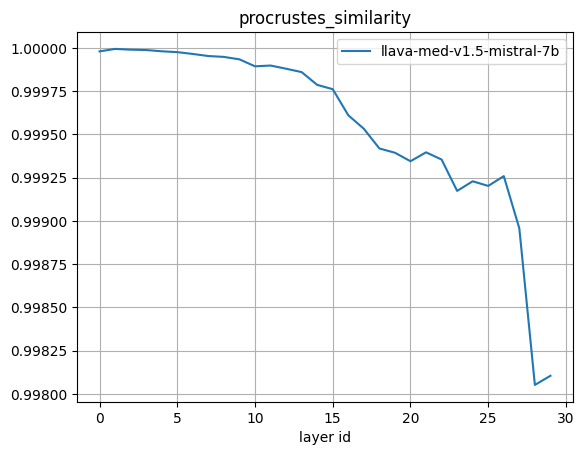

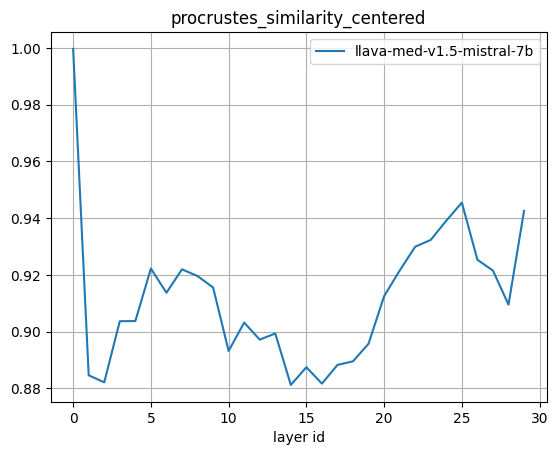

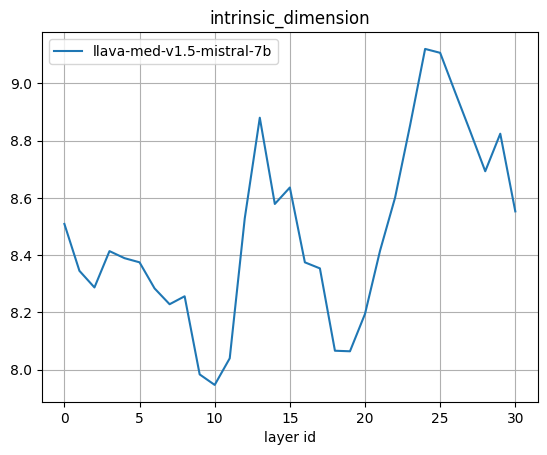

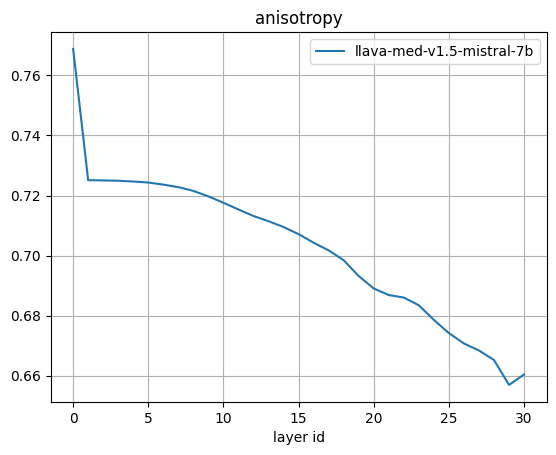

In [23]:
for metric_name in all_results.keys():
    plt.title(metric_name)
    plt.grid()
    plt.xlabel("layer id")
    for model_name in all_results[metric_name].keys():
        plt.plot(all_results[metric_name][model_name][1:], label=model_name)
    plt.legend()
    plt.show()

#### Results for visial and text embedding separate

In [5]:
with open('/workspace/results_img_text_emb.json', 'r', encoding='utf-8') as file:
    all_results_emb_text = json.load(file)

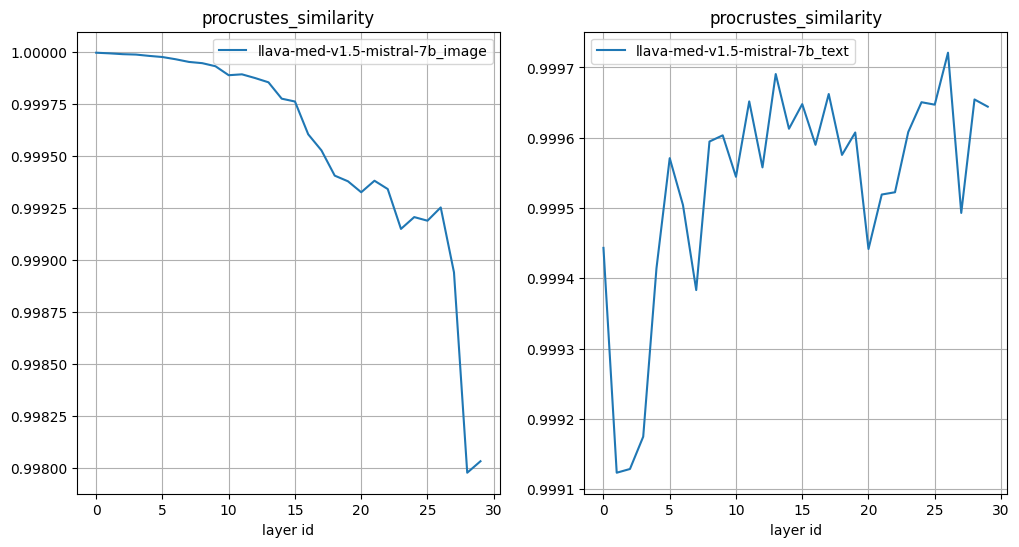

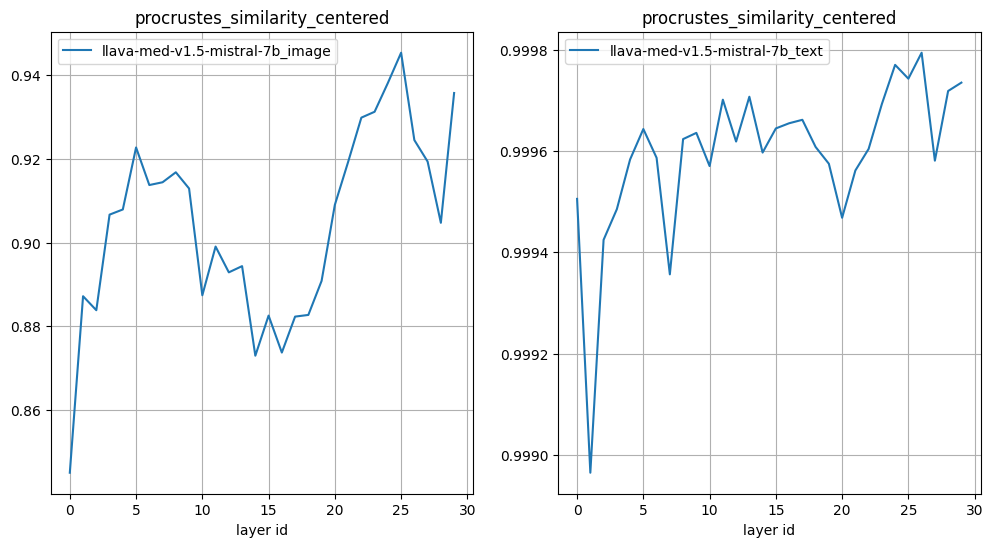

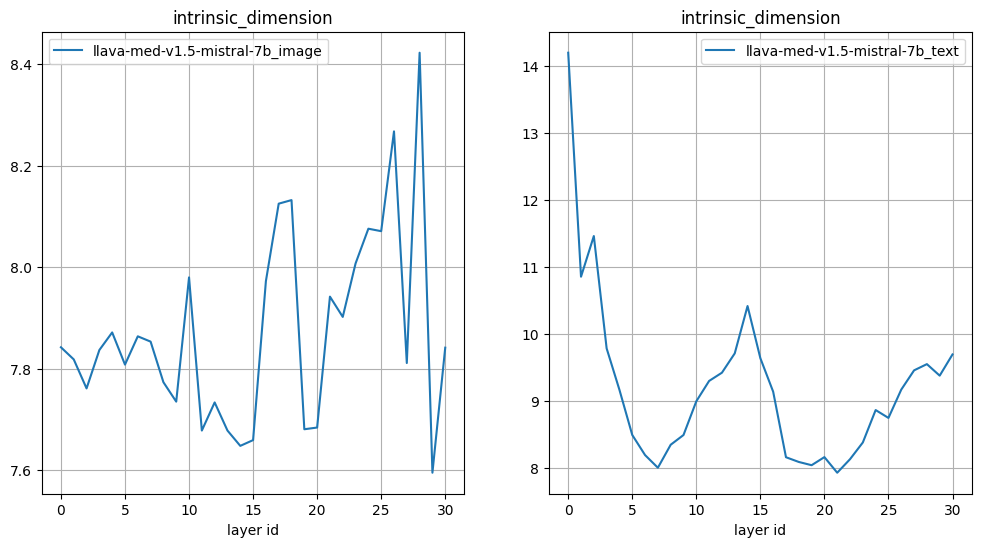

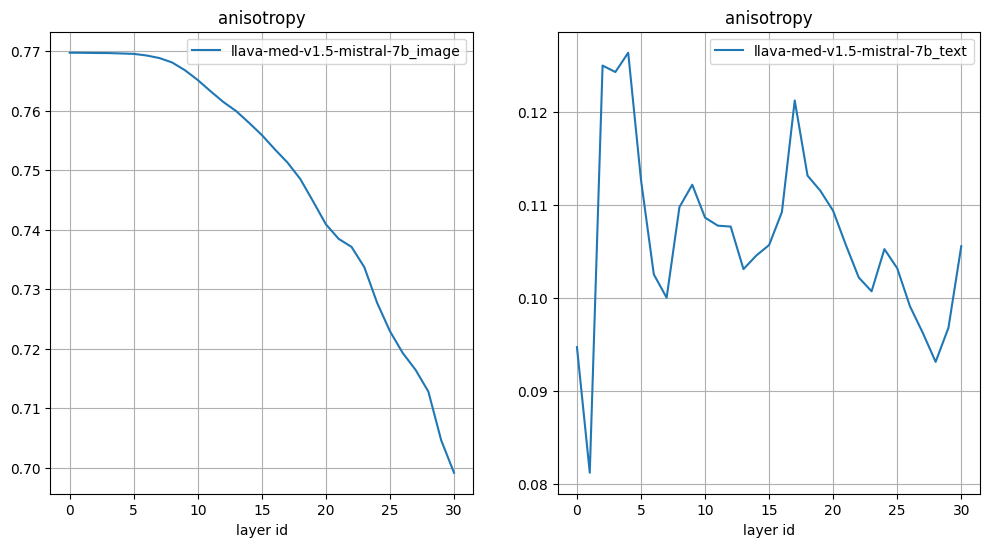

In [6]:
for metric_name in all_results_emb_text.keys():
    _, axs = plt.subplots(1, 2, figsize=(12, 6))
    for model_name in all_results_emb_text[metric_name].keys():

        text_metric = all_results_emb_text[metric_name][model_name]['text'][1:]
        img_metric = all_results_emb_text[metric_name][model_name]['img'][1:]
        axs[0].plot(img_metric, label=f'{model_name}_image')
        axs[1].plot(text_metric, label=f'{model_name}_text')

    for ax in axs:
        ax.set_title(metric_name)
        ax.grid()
        ax.set_xlabel("layer id")
        ax.legend()
        
    plt.show()